In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import optimize
%matplotlib inline

In [2]:
data = loadmat('ex4data1.mat')

In [3]:
X = data['X'] #5000x400.
intNumSamples = X.shape[0]
'''
Add column for bias term.
'''
inputSize = X.shape[1] #400

X = np.insert(X,0,np.ones(intNumSamples),axis =1) #5000x401.
y = data['y'] #5000x1.

hiddenSize = 25
outputSize = 10

(-0.5, 199.5, 19.5, -0.5)

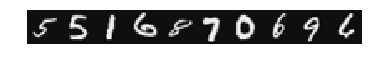

In [4]:
indexRandRows = np.random.choice(X.shape[0],10)
'''
reshape(-1,20) rolls each 1x400 row back into a 20x20 grid.
we can plot these as an image since each grid is a 20x20 grid of grayscale pixel values.
'''
plt.imshow(X[indexRandRows,1:].reshape(-1,20).T, cmap = 'gray')
plt.axis('off')

In [5]:
class NeuralNetwork:
    def __init__(self, inputLayerSize,hiddenLayerSize,outputLayerSize):
        '''
        Layer sizes for three layer nn. Include bias terms.
        '''
        self.inputLayerSize = inputLayerSize #401.
        self.hiddenLayerSize = hiddenLayerSize #26.
        self.outputLayerSize = outputLayerSize #10.
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def sigmoidGrad(self,z):
        sig = self.sigmoid(z)
        return np.multiply(sig,(1 - sig))
    def unrollThetas(self, allParameters):
        theta1Length = self.inputLayerSize*(self.hiddenLayerSize-1)
        initialTheta = np.matrix(allParameters)
        '''
        Need to separate the thetas so that we can forwardPropagate,getCost, and backPropagate.
        '''
        self.theta1 = np.matrix(np.reshape(initialTheta[:,:theta1Length],(self.hiddenLayerSize-1,self.inputLayerSize))) #25x401.
        self.theta2 = np.matrix(np.reshape(initialTheta[:,theta1Length:],(self.outputLayerSize,self.hiddenLayerSize))) #10x26.
    def rollThetas(self,theta1,theta2):
        '''
        Need to roll all parameters into one array because fmin only has one initialTheta parameter.
        '''
        self.allParameters = np.concatenate((theta1.ravel(),theta2.ravel()))
        return self.allParameters
    def forwardPropagate(self,X,theta1,theta2):
        numSamples = X.shape[0]
        '''
        Input layer.
        '''
        self.a1 = X
        self.z2 = np.dot(self.a1,theta1.T)
        '''
        Hidden layer.
        '''
        self.a2 = self.sigmoid(self.z2)
        self.a2 = np.insert(self.a2,0,np.ones(numSamples),axis =1)
        '''
        Output layer.
        '''
        self.z3 = np.dot(self.a2,theta2.T)
        self.hypothesis = np.matrix(self.sigmoid(self.z3))
        return self.hypothesis
    def getCost(self,allParameters,X,y,regFactor):
        '''
        unroll allParameters into Theta1 and Theta2.
        '''
        self.unrollThetas(allParameters)
        
        self.forwardPropagate(X,self.theta1,self.theta2) #hypothesis is mxk.
        numSamples,numLabels = self.hypothesis.shape 
        J = 0
        for i in range(1,numLabels+1):
            tempY = np.matrix([1 if label==i else 0 for label in y]).T #mx1
            tempA3 = self.hypothesis[:,i-1]
            J -= (np.dot(tempY.T,np.log(tempA3)) + np.dot((1-tempY.T),np.log(1-tempA3)))
        J = J/numSamples
        '''
        Regularized portion of cost function.
        '''
        R = (np.sum(np.sum(np.square(self.theta1[:,1:])))+np.sum(np.sum(np.square(self.theta2[:,1:]))))*regFactor/2/numSamples
        self.J = J+R
        return self.J
    def backPropagate(self,allParameters,X,y,regFactor):
        '''
        unroll allParameters into Theta1 and Theta2.
        '''
        self.unrollThetas(allParameters)
        '''
        propagate forward so that you can calculate the activation functions.
        '''
        self.forwardPropagate(X,self.theta1,self.theta2) #hypothesis is 5000x10.
        numSamples, numLabels = self.hypothesis.shape
        hiddenLayerSize = self.z2.shape[1]
        Z2 = np.insert(self.z2,0,np.ones(numSamples),axis =1)
        
        Delta1 = np.zeros(theta1.shape) #25x401.
        Delta2 = np.zeros(theta2.shape) #10x26.
        
        yMatrix = np.matrix(pd.get_dummies(y.ravel())) #5000x10.
        for t in range(0,numSamples):
            d3 = (self.hypothesis[t,:] - yMatrix[t,:]).T #10x1
            '''
            theta2 = 10x26. => theta2.Txd3 = 26x1. Z2 = 5000x26 (with bias column).
            element wise multiplication of (theta2.Txd3)x(z2[t,:].T) results in a 26x1 vector.
            '''
            d2 = np.matrix(np.multiply(np.dot(self.theta2.T,d3),self.sigmoidGrad(Z2[t,:]).T)) #26x1.
            d2 = d2[1:,:] #25x1.
            a1Matrix = np.matrix(self.a1[t,:])
            a2Matrix = np.matrix(self.a2[t,:])
            Delta1 += np.dot(d2,a1Matrix) #a1Matrix = 1x401 => Delta1 = 25x401.
            Delta2 += np.dot(d3,a2Matrix) #a2Matrix = 1x26. => Delta2 = 10x26.
        Delta1 = Delta1/numSamples
        Delta2 = Delta2/numSamples
        '''
        Regularization
        '''
        Delta1[:,1:] = Delta1[:,1:] + self.theta1[:,1:]*regFactor/numSamples
        Delta2[:,1:] = Delta2[:,1:] + self.theta2[:,1:]*regFactor/numSamples
        
        self.grad = np.concatenate((Delta1.ravel(),Delta2.ravel()))
        return self.grad
    def numericalGradient(self,allParameters,X,y,regFactor,numComputations):
        '''
        Calculate the slope of the cost function and use it to check that backPropagate() was implemented correctly.
        '''
        self.gradApprox = np.zeros(numComputations)
        numSamples = allParameters.shape[0]
        e = 10**-4
        
        randIndexes = np.random.choice(numSamples,numComputations)
        for i in range(0,numComputations):
            thetaPlus = np.matrix(allParameters)
            thetaMinus = np.matrix(allParameters)
            thetaPlus[0,randIndexes[i]] = allParameters[randIndexes[i]] + e
            thetaMinus[0,randIndexes[i]] = allParameters[randIndexes[i]] - e
            self.gradApprox[i] = (self.getCost(thetaPlus,X,y,regFactor) - self.getCost(thetaMinus,X,y,regFactor))/2/e       
        return self.gradApprox,randIndexes
    def checkNNGradient(self,allParameters,X,y,regFactor,numComparisons):
        numGrad, randIndexes = self.numericalGradient(allParameters,X,y,regFactor,numComparisons)
        bpGrad = self.backPropagate(allParameters,X,y,regFactor)
        bpGrad = bpGrad[randIndexes]
        
        diff = np.linalg.norm(numGrad - bpGrad)/np.linalg.norm(numGrad+bpGrad)
        return diff,numGrad,bpGrad[:numComparisons],randIndexes
    def randInitializeWeights(self, initialEpsilon = 0.12):
        '''
        weights should be a random value in [-initialEpsilon,initialEpsilon].
        '''
        self.theta1 = np.random.rand(self.hiddenLayerSize -1, self.inputLayerSize)*2*initialEpsilon - initialEpsilon
        self.theta2 = np.random.rand(self.outputLayerSize,self.hiddenLayerSize)*2*initialEpsilon - initialEpsilon
        self.rollThetas(self.theta1,self.theta2)
        return self.allParameters
    def minimizeCost(self,allParameters,X,y,regFactor,optMethod = None, maxIterations = 250):
        self.fmin = optimize.minimize(fun=self.getCost,x0=allParameters,method = optMethod, 
                                      jac = self.backPropagate ,args=(X,y,regFactor), options = {'maxiter':maxIterations})
        return self.fmin
    def predict(self,allParameters,X,y):
        self.unrollThetas(allParameters)
        self.forwardPropagate(X,self.theta1,self.theta2)
        '''
        Remember that labels go from 1 - 10.
        '''
        self.allPredictions = np.argmax(self.hypothesis, axis =1) + 1
        self.predictionAccuracy = round(100*np.mean(self.allPredictions == y),2)
        return self.predictionAccuracy

In [6]:
weights = loadmat('ex4weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [7]:
theta1 = weights['Theta1'] #25x401
theta2= weights['Theta2'] #10x26
'''
Roll all the weights into a 1-D array.  This is necessary because the optmization algorithms 
only accept one parameter for the weights.
'''
nn = NeuralNetwork(inputSize+1,hiddenSize+1,outputSize)
initialTheta = nn.rollThetas(theta1,theta2)
initialTheta.shape

(10285,)

In [8]:
'''
Check that the unregularized and regularized portions of cost function are working properly.
'''
for regFactor in [0,1]:
    cost = nn.getCost(initialTheta,X,y,regFactor)
    print('Cost with lambda = ' + str(regFactor) + ': ' + str(cost[0,0]))
'''
Check that the gradient of the sigmoid function is being calculated correctly.
'''
dummy = np.matrix([-1, -0.5, 0, 0.5, 1])
g = nn.sigmoidGrad(dummy)
print('\nSigmoid Gradient evaluated at ' + str(dummy) + ':')
print(g)

Cost with lambda = 0: 0.287629165161319
Cost with lambda = 1: 0.3837698590909237

Sigmoid Gradient evaluated at [[-1.  -0.5  0.   0.5  1. ]]:
[[0.19661193 0.23500371 0.25       0.23500371 0.19661193]]


In [9]:
'''
Randomly initialize weights.  Avoid initializing weights to zeros because that will lead to identical parameters going
into each hidden unit for each input.
'''
randWeights = nn.randInitializeWeights()
numComparisons = 25
'''
Randomly compare numComparisons of the gradient values from the backpropagation algorithm to those calculated numerically and 
ensure that they are close in value.  Avoid using the numericalGrad algorithm in when minimizing the cost function because it 
is slow.
'''
normDiff, numGrad,bpGrad,randIndexes = nn.checkNNGradient(randWeights,X,y,regFactor,numComparisons)
numLoops = numComparisons
numMaxLoops = 10
'''
Let's avoid printing out more than numMaxLoops comparisons.
'''
try:
    for i in range(0,numMaxLoops):
        numGradient = '{:.3e}'.format(float(numGrad[i]))
        bpGradient = '{:.3e}'.format(float(bpGrad[i]))
        print('Index: %s | numericalGrad: %s | backPropagate: %s' %(randIndexes[i],numGradient,bpGradient))
    numLoops = numMaxLoops
except:
    pass
    
normDiff = '{:.3e}'.format(float(normDiff))
print('\nThe relative difference between the two solutions is %s; this value should be ' \
      'less than 1e-9 if backPropagate was implemented correctly.' %(normDiff))
print('\nNote that we printed %s of the %s gradient comparison(s) that were made.' %(numLoops,numComparisons))

Index: 1383 | numericalGrad: 1.517e-04 | backPropagate: 1.517e-04
Index: 1024 | numericalGrad: 3.543e-04 | backPropagate: 3.543e-04
Index: 8260 | numericalGrad: -1.438e-05 | backPropagate: -1.438e-05
Index: 62 | numericalGrad: -1.757e-05 | backPropagate: -1.757e-05
Index: 10064 | numericalGrad: 1.868e-01 | backPropagate: 1.868e-01
Index: 5985 | numericalGrad: -1.281e-05 | backPropagate: -1.281e-05
Index: 4257 | numericalGrad: 1.048e-02 | backPropagate: 1.048e-02
Index: 3664 | numericalGrad: 1.549e-04 | backPropagate: 1.549e-04
Index: 10260 | numericalGrad: 1.865e-01 | backPropagate: 1.865e-01
Index: 6798 | numericalGrad: -2.116e-05 | backPropagate: -2.116e-05

The relative difference between the two solutions is 5.028e-11; this value should be less than 1e-9 if backPropagate was implemented correctly.

Note that we printed 10 of the 25 gradient comparison(s) that were made.


In [10]:
regFactor = 1
optMethod = 'TNC' #Truncated Newton Method.
maxIterations = 250 
'''
Minimize the cost function.
'''
fmin = nn.minimizeCost(randWeights,X,y,regFactor,optMethod,maxIterations)
print(fmin)
calcWeights = fmin['x']
'''
Use the weights that minimized the cost function to predict values.
'''
nn.predict(calcWeights,X,y)

print('\nPrediction accuracy: %s%%.' %(nn.predictionAccuracy))
print('Note that we used the %s optimization algorithm to minimize the cost function.' %(optMethod))

     fun: matrix([[0.33534688]])
     jac: array([ 3.91553012e-05, -1.11518225e-06, -6.70050235e-07, ...,
       -3.39656583e-04, -1.88747701e-04, -1.02241037e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 19
  status: 3
 success: False
       x: array([-0.7217267 , -0.00557591, -0.00335025, ...,  0.87218384,
       -0.09506831,  2.52653745])

Prediction accuracy: 99.16%.
Note that we used the TNC optimization algorithm to minimize the cost function.
